In [1]:
import tensorflow as tf # Imports tensorflow
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization,Conv2D, MaxPooling2D,concatenate, Conv2DTranspose, Add,  GlobalAveragePooling2D,Input,  Multiply, UpSampling2D, Resizing
from tensorflow.keras.metrics import Accuracy,Recall,Precision,AUC
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
from tensorflow.image import resize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import seaborn as sns
#import imblearn
#from keras.optimizers import Adam
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import os
import sklearn.metrics as m
from glob import glob
from sklearn.model_selection import train_test_split
import skimage.color
import skimage.filters
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
gr_shape=(128,128,1)
img_shape = (128,128,3)
input_dir="C:/Users/nidhi/Downloads/data set sample/LIDC-IDRI-slices"
images=[]
masks=[]
y=[]
Thres = 5000/255

In the provided code, the following preprocessing steps are performed:

1. Loading Images and Masks:
   - Images and masks are loaded from the specified directories using `image.load_img()` from the Keras preprocessing module. They are resized to the `img_shape`.
   - The images are stored in the `images` list, and the masks are stored in separate lists (`mask0`, `mask1`, `mask2`, `mask3`).

2. Processing Masks and Labels:
   - For each nodule, the white pixel sum is computed for each mask (`mask0`, `mask1`, `mask2`, `mask3`).
   - If the count of white pixels exceeds the threshold (`Thres`) for more than 2 masks, it is labeled as 1 (positive), and the mask with the maximum white pixel sum is chosen. Otherwise, it is labeled as 0 (negative), and the mask with the minimum white pixel sum is chosen.
   - The images, masks, and labels are stored in lists (`images`, `masks`, `y`).

3. Normalization:
   - Images and masks are divided by 255 to normalize pixel values between 0 and 1.

4. Handling Missing Values:
   - Any NaN values in images and masks are replaced with 0 using `np.nan_to_num()`.

5. Data Augmentation:
   - No explicit data augmentation is performed in this snippet.

6. Data Concatenation:
   - Additional data is added to the training set (`x_train_added`, `y_train_added`) by appending a portion of the test set (`x_test`, `y_test`).

Overall, the preprocessing in this code involves loading images and masks, processing masks to determine labels, normalizing the pixel values, handling missing values, and concatenating data for training.

In [3]:
# Iterate over patients in the input directory
for patient in os.listdir(input_dir):
    # Check if the item is a directory
    patient_dir = os.path.join(input_dir, patient)
    if not os.path.isdir(patient_dir):
        continue

    # Break loop if images list exceeds 10000
    if len(images) > 10000:
        break

    # Iterate over nodules in the patient directory
    for nodule in os.listdir(patient_dir):
        nodule_dir = os.path.join(patient_dir, nodule)
        if not os.path.isdir(nodule_dir):
            continue

        mask0 = []
        mask1 = []
        mask2 = []
        mask3 = []

        # Load images
        for filename in glob(os.path.join(nodule_dir, 'images', '*.png')):
            img = image.load_img(filename, target_size=img_shape)
            img = np.asarray(img)
            images.append(img)

        # Load masks
        for i, mask_dir in enumerate([mask0, mask1, mask2, mask3]):
            for filename in glob(os.path.join(nodule_dir, f'mask-{i}', '*.png')):
                img = image.load_img(filename, target_size=img_shape)
                img = np.asarray(img)
                mask_dir.append(img)

        # Process masks and labels
        for i in range(len(mask0)):
            white_sum = np.array([mask.sum() for mask in [mask0[i], mask1[i], mask2[i], mask3[i]]])
            cnt = np.sum(white_sum > Thres)
            if cnt > 2:
                y.append(1)
                max_index = white_sum.argmax()
                masks.append([mask0[i], mask1[i], mask2[i], mask3[i]][max_index])
            else:
                y.append(0)
                min_index = white_sum.argmin()
                masks.append([mask0[i], mask1[i], mask2[i], mask3[i]][min_index])

In [4]:
images=np.array(images)/255
masks=np.array(masks)/255
label=np.array(y)
print(images.shape)
print(masks.shape)
print(label.shape)

(10011, 128, 128, 3)
(10011, 128, 128, 3)
(10011,)


In [5]:
yy=pd.DataFrame(label)
yy.value_counts()

1    5097
0    4914
Name: count, dtype: int64

In [6]:
x_train,x_test,y_train,y_test,mask_train,mask_test = train_test_split(images,label,masks,train_size=0.8, random_state=7)
print(x_train.shape)
print(mask_train.shape)

(8008, 128, 128, 3)
(8008, 128, 128, 3)


In [7]:
images = np.nan_to_num(images)
masks = np.nan_to_num(masks )
np.isnan(masks).sum()
masks.shape

(10011, 128, 128, 3)

In [8]:
x_train_added = np.vstack([x_train,x_test[:2000]])
y_train_added = np.concatenate((y_train,y_test[:2000]))
print(x_test.shape)
print(mask_test.shape)
Name='lidcUnet0'


(2003, 128, 128, 3)
(2003, 128, 128, 3)


In [9]:
def mean_iou(y_true, y_pred):
    # Define a function to calculate IoU
    def iou(y_true, y_pred):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + K.epsilon()) / (union + K.epsilon()), axis=0)
        return iou
    
    # Compute IoU for each class
    ious = iou(y_true, y_pred)
    # Take the mean over classes (excluding the background)
    return K.mean(ious)

# Define the Matthews correlation coefficient (MCC) custom metric function
def mcc(y_true, y_pred):
    y_pred_pos = tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = tf.keras.backend.sum(y_pos * y_pred_pos)
    tn = tf.keras.backend.sum(y_neg * y_pred_neg)

    fp = tf.keras.backend.sum(y_neg * y_pred_pos)
    fn = tf.keras.backend.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = tf.keras.backend.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn) + tf.keras.backend.epsilon())

    return numerator / (denominator + tf.keras.backend.epsilon())

In [12]:
Name='lidcUnet0'
def segment_model():
    inputs = keras.Input(shape=img_shape, name="img")
    c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (inputs)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.1) (c1)
    down1 = MaxPooling2D((2, 2)) (c1)
    
    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (down1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.2) (c2)
    p2 = MaxPooling2D((2, 2)) (c2)
    
    c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.2) (c3)    
    p3 = MaxPooling2D((2, 2)) (c3)
    
    c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.2) (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    
    c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.3) (c5)
    
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(0.2) (c6)
    
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)
    c7 = BatchNormalization()(c7)
    
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)
    c8 = BatchNormalization()(c8)
    
    u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)
    c9 = BatchNormalization()(c9)
    
    outputs = Conv2D(3, (1, 1), activation='sigmoid') (c9)
    model = keras.Model(inputs, outputs, name=Name)
    # model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.01), 
    #               loss='binary_crossentropy', metrics=['accuracy',Recall(),Precision(),AUC()])
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', metrics=['accuracy',Precision(),Recall(), AUC(),mean_iou, mcc])
    model.summary()
    plot_model(model, to_file=Name+'seg.png',show_shapes= True , show_layer_names=True)
    return model
unet = segment_model()


Model: "lidcUnet0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img (InputLayer)            [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_18 (Conv2D)          (None, 128, 128, 32)         896       ['img[0][0]']                 
                                                                                                  
 batch_normalization_12 (Ba  (None, 128, 128, 32)         128       ['conv2d_18[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 dropout_9 (Dropout)         (None, 128, 128, 32)         0         ['batch_normalization_

In [13]:
with tf.device('/gpu:0'):
    results = unet.fit(x_train,mask_train, validation_data=(x_test,mask_test), batch_size=32, epochs=150,)
unet.save(Name+'.h5')
model = unet

Epoch 1/150
251/251 [==============================] - 683s 3s/step - loss: 0.3505 - accuracy: 0.5912 - precision_1: 0.0328 - recall: 0.4005 - auc: 0.7741 - mean_iou: 0.0131 - mcc: 0.3294 - val_loss: 0.0969 - val_accuracy: 0.2742 - val_precision_1: 0.2244 - val_recall: 0.5587 - val_auc: 0.8788 - val_mean_iou: 0.0347 - val_mcc: 0.3508
Epoch 2/150
251/251 [==============================] - 577s 2s/step - loss: 0.0375 - accuracy: 0.6732 - precision_1: 0.7331 - recall: 0.5598 - auc: 0.9726 - mean_iou: 0.0629 - mcc: 0.6344 - val_loss: 0.0250 - val_accuracy: 0.6268 - val_precision_1: 0.5345 - val_recall: 0.7466 - val_auc: 0.9828 - val_mean_iou: 0.1162 - val_mcc: 0.6202
Epoch 3/150
251/251 [==============================] - 593s 2s/step - loss: 0.0159 - accuracy: 0.6327 - precision_1: 0.7664 - recall: 0.6087 - auc: 0.9905 - mean_iou: 0.1149 - mcc: 0.6800 - val_loss: 0.0229 - val_accuracy: 0.6591 - val_precision_1: 0.4537 - val_recall: 0.9072 - val_auc: 0.9954 - val_mean_iou: 0.1692 - val_mcc:

c:\Users\nidhi\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
 pd.DataFrame.from_dict(results.history).to_csv(Name+'new.csv',index=False)

In [15]:
new_impr= unet.predict(x_train)

251/251 [==============================] - 105s 416ms/step


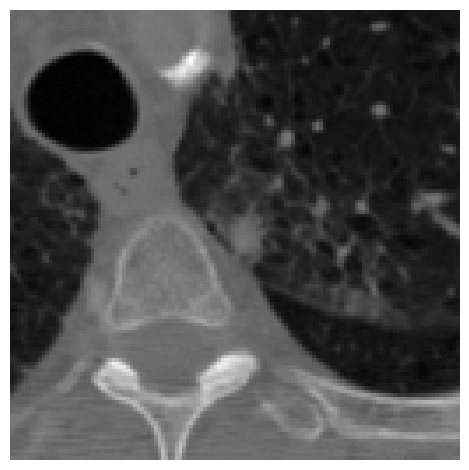

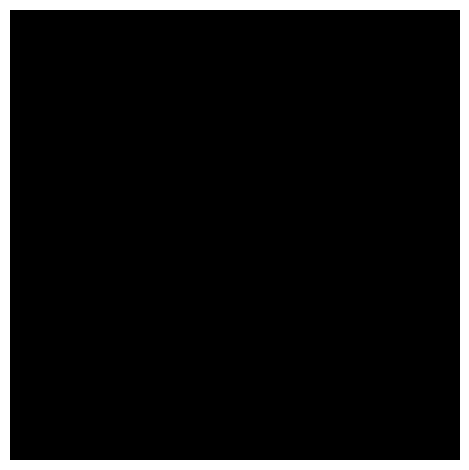

1/1 [==============================] - 0s 98ms/step


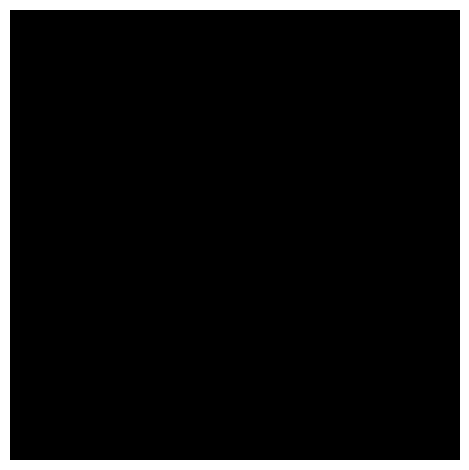

In [17]:

img_id=1019
new_img= np.array(x_train[img_id])
plt.imshow(x_train[img_id])
plt.axis('off')
plt.tight_layout()
plt.show()
plt.imshow(mask_train[img_id])
plt.axis('off')
plt.tight_layout()
plt.show()
new_img = new_img.reshape(1,128,128,3)
new_impr= model.predict(new_img)
plt.imshow(new_impr[0])
plt.axis('off')
plt.tight_layout()
#plt.savefig("Activation_Layer5D7"+'.png')
plt.show()


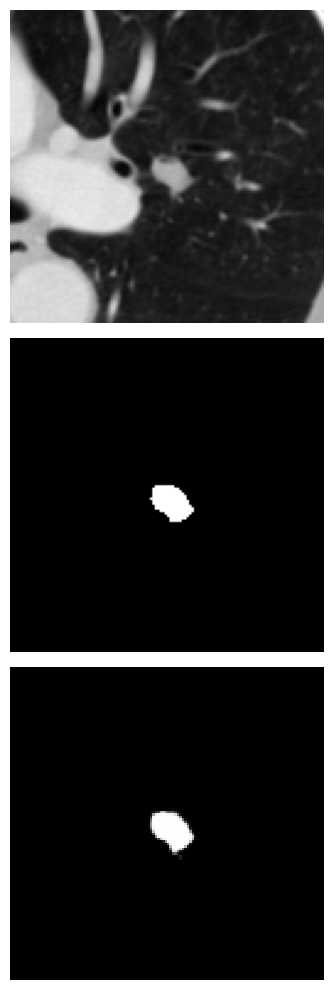

In [16]:
img_id=1789
fig = plt.figure(figsize=(10,10))
a = fig.add_subplot(3, 1, 1)
plt.imshow(x_train[img_id])
#a.set_title("original",fontsize=10)
plt.axis('off')
a = fig.add_subplot(3, 1, 2)
plt.imshow(mask_train[img_id])
#a.set_title("True Mask",fontsize=10)
plt.axis('off')
a = fig.add_subplot(3, 1, 3)
plt.imshow(new_impr[img_id],interpolation='nearest')
#a.set_title("Predicted",fontsize=10)
plt.axis('off')
plt.tight_layout()
plt.savefig("Segmentation"+str(img_id)+'.png')
plt.show()

In [18]:
# Assuming model is your trained model and x_test contains the test images
prediction = model.predict(x_test)
# Reshape y_score to match the shape of y_test
predictions_binary = prediction.max(axis=(1, 2, 3))
threshold = 0.65
predictions_binary = (predictions_binary > threshold).astype(np.uint8)

63/63 [==============================] - 26s 407ms/step


In [19]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Define the threshold for binarization
threshold = 0.65

# Function to convert the mask to binary format
def binarize_mask(mask):
    return np.where(mask > threshold, 255, 0).astype(np.uint8)

# Function to find contours and compute area of white regions
def compute_white_area(mask):
    # Convert the mask to binary format
    binary_mask = binarize_mask(mask)
    # Convert the binary mask to a single-channel image
    binary_mask_single_channel = cv2.cvtColor(binary_mask, cv2.COLOR_RGB2GRAY)
    # Find contours of white regions
    contours, _ = cv2.findContours(binary_mask_single_channel, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Compute total area of white regions
    total_area = sum(cv2.contourArea(contour) for contour in contours)
    return total_area

# Calculate white area for mask_train[img_id]
mask_train_white_area = compute_white_area(mask_train[img_id])
print("White area in mask_train:", mask_train_white_area)

# Calculate white area for new_impr[img_id]
new_impr_white_area = compute_white_area(new_impr[img_id])
print("White area in new_impr:", new_impr_white_area)

# Display the images
fig = plt.figure(figsize=(10,10))
a = fig.add_subplot(3, 1, 1)
plt.imshow(x_train[img_id])
plt.axis('off')

a = fig.add_subplot(3, 1, 2)
plt.imshow(mask_train[img_id])
plt.axis('off')

a = fig.add_subplot(3, 1, 3)
plt.imshow(new_impr[img_id], interpolation='nearest')
plt.axis('off')

plt.tight_layout()
plt.show()


White area in mask_train: 0


IndexError: index 1019 is out of bounds for axis 0 with size 1

***Confusion Matrix***

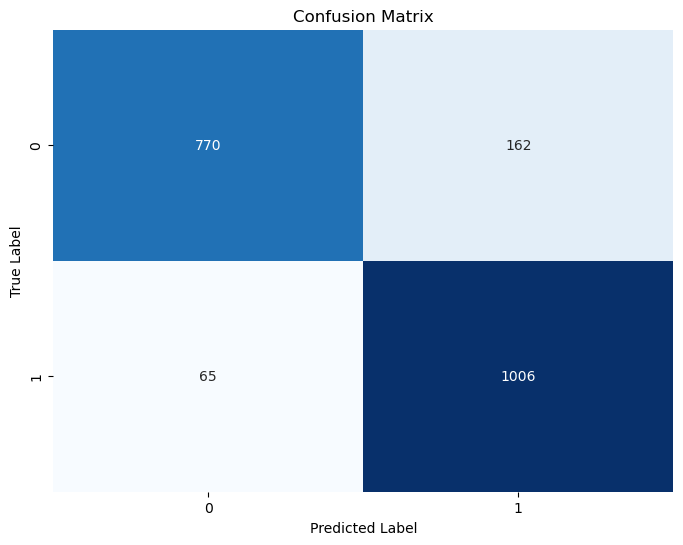

In [20]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)

# 4. Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


***Precision-Recall Curve***

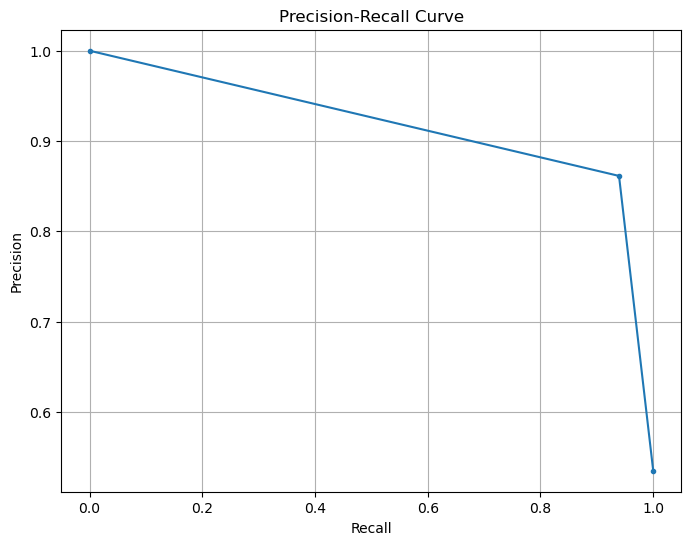

In [21]:

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_test, predictions_binary)

# Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


***Receiver Operating Characteristic (ROC) Curve***

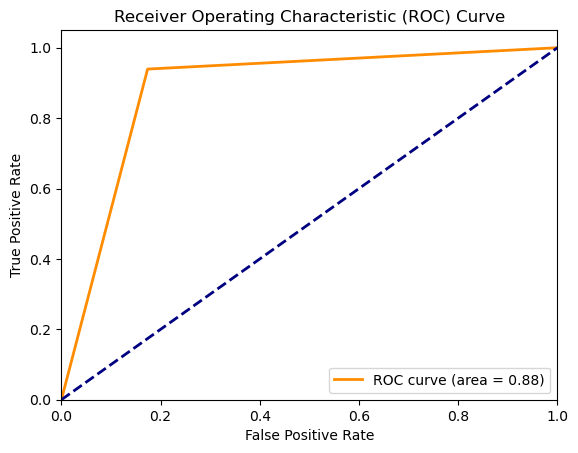

In [22]:

# Assuming y_test contains the true labels
fpr, tpr, thresholds = roc_curve(y_test, predictions_binary)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

***Accuracy vs. Threshold Plot***

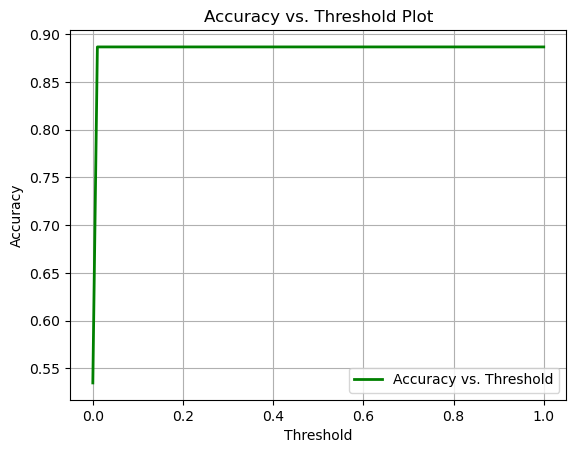

In [23]:

# Assuming y_test contains the true labels
# and y_score contains the predicted scores or probabilities
thresholds = np.linspace(0, 1, 100)
accuracies = []

for threshold in thresholds:
    y_pred = (predictions_binary >= threshold).astype(int)
    accuracy = np.mean(y_pred == y_test)
    accuracies.append(accuracy)

# Plotting the Accuracy vs. Threshold plot
plt.figure()
plt.plot(thresholds, accuracies, color='green', lw=2, label='Accuracy vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Threshold Plot')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


***Classification report***

***Training and Validation mIoU***

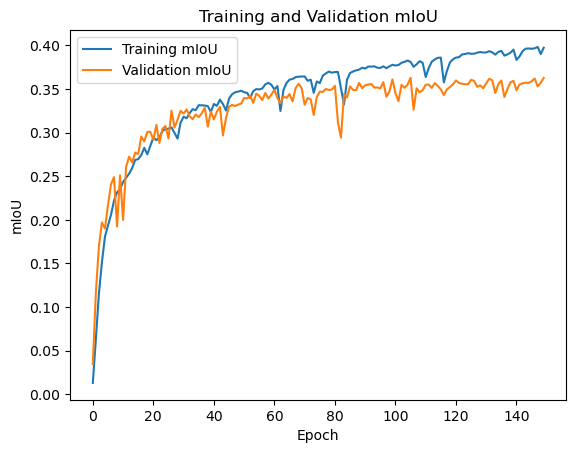

In [24]:


# Retrieve the mIoU values from the history object
train_miou = results.history['mean_iou']
val_miou = results.history['val_mean_iou']

# Plot mIoU values
plt.plot(train_miou, label='Training mIoU')
plt.plot(val_miou, label='Validation mIoU')
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.title('Training and Validation mIoU')
plt.legend()
plt.show()
